<a href="https://colab.research.google.com/github/istiak9999/Malicious-url-classification-using-1d-cnn-and-Bidirectional-Lstm/blob/master/malicious_url_with_1d_CNN_%26_Biderectional_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

In [ ]:
!nvidia-smi

In [ ]:
# install additional library
!pip install tldextract -q

# import library
import numpy as np
import pandas as pd
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse
import tldextract

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# set random seed
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# other setup
%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 50)
pio.templates.default = "presentation"
pd.options.plotting.backend = "plotly"
deprecation._PRINT_DEPRECATION_WARNINGS = False

     |████████████████████████████████| 93 kB 2.5 MB/s 


In [ ]:
# load data
data = pd.read_csv('/content/drive/MyDrive/Machine Learning Dataset/Malicious url researchpaper data/malicious_phish _kaggle.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
data.shape

(651191, 2)

In [ ]:
data.rename(columns={'type':'label'},inplace=True)

In [ ]:
data.describe()

,url,label
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [ ]:
data['label'].unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=0)

In [ ]:
def parsed_url(url):
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    subdomain, domain, domain_suffix = ('<empty>' if extracted == '' else extracted for extracted in tldextract.extract(url))   
    
    return [subdomain, domain, domain_suffix]

def extract_url(data):
    # parsed url
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain', 'domain_suffix'])
    
    # concat extracted feature with main data
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)
    
    return data

def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')
    
    # scale log base 10
    data['values'] = np.log10(data['values'])
    
    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())
    
    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)
    
    return data
def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')
    
    # scale log base 10
    data['values'] = np.log10(data['values'])
    
    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())
    
    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)
    
    return data
def plot(data, n_group, title):
    data = get_frequent_group(data, n_group)
    fig = px.bar(data, x=data.columns[1], y='values', color='label')
    fig.update_layout(title=title)
    fig.show()



In [ ]:
# extract url
data = extract_url(data)
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [ ]:
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)

# fit only on training data
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())

train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])

print('Before tokenization: ')
print(train_data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(train_seq[0])

Before tokenization: 
oreilly.com/catalog/9780596007072/

After tokenization: 
[3, 11, 2, 7, 14, 14, 27, 12, 9, 3, 13, 6, 9, 5, 4, 5, 14, 3, 21, 6, 36, 38, 31, 24, 34, 36, 39, 24, 24, 38, 24, 38, 25, 6]


In [ ]:
print(n_char)

332


In [ ]:
sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Before padding: \n {train_seq[0]}')
train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)
print(f'After padding: \n {train_seq[0]}')

Before padding: 
 [3, 11, 2, 7, 14, 14, 27, 12, 9, 3, 13, 6, 9, 5, 4, 5, 14, 3, 21, 6, 36, 38, 31, 24, 34, 36, 39, 24, 24, 38, 24, 38, 25, 6]
After padding: 
 [ 3 11  2  7 14 14 27 12  9  3 13  6  9  5  4  5 14  3 21  6 36 38 31 24
 34 36 39 24 24 38 24 38 25  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
sequence_length

234

In [ ]:
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,phishing,<empty>,oreilly,com
1,content.usatoday.com/community/tags/topic.aspx...,benign,content,usatoday,com
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,benign,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,estudiomadrid,com
3,news.stanford.edu/news/2006/february22/med-ill...,benign,news,stanford,edu
4,skate-works.com/oakland_university_?b=1,benign,<empty>,skate-works,com


In [ ]:
unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}
    
    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    
    # count unique value
    unique_value[feature] = label_index['<unknown>']
    
    # encode
    train_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in val_data.loc[:, feature]]
    
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,phishing,0,0,0
1,content.usatoday.com/community/tags/topic.aspx...,benign,1,1,0
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,benign,2,2,0
3,news.stanford.edu/news/2006/february22/med-ill...,benign,3,3,1
4,skate-works.com/oakland_university_?b=1,benign,0,4,0


In [ ]:
unique_value

{'subdomain': 35756, 'domain': 129162, 'domain_suffix': 830}

In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
for data in [train_data, val_data]:
  data['label']=encoder.fit_transform(data['label'])

In [ ]:
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,3,0,0,0
1,content.usatoday.com/community/tags/topic.aspx...,0,1,1,0
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,0,2,2,0
3,news.stanford.edu/news/2006/february22/med-ill...,0,3,3,1
4,skate-works.com/oakland_university_?b=1,0,0,4,0


In [ ]:
train_data['label'].unique()

array([3, 0, 1, 2])

In [ ]:
# create train data
train_x = [train_seq, train_data['subdomain'], train_data['domain'], train_data['domain_suffix']]
train_y = train_data['label'].values
val_x=[val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
val_y=val_data['label'].values

In [ ]:
print(sequence_length, n_char, unique_value,)

234 332 {'subdomain': 35756, 'domain': 129162, 'domain_suffix': 830}


#Create Model

In [ ]:
from keras.layers import LSTM

In [ ]:
def convolution_block(x):
    conv_3_layer = layers.Conv1D(256, 3, padding='same', activation='elu')(x)
    conv_5_layer = layers.Conv1D(256, 5, padding='same', activation='elu')(x)
    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])
    conv_layer=layers.MaxPool1D(pool_size=2)(conv_layer)
    conv_layer=layers.Bidirectional(LSTM(256,return_sequences=True))(conv_layer)
    conv_layer = layers.Flatten()(conv_layer)

    return conv_layer

def embedding_block(unique_value, size, name):
    input_layer = layers.Input(shape=(1,), name=name + '_input')
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)
    return input_layer, embedding_layer

def create_model(sequence_length, n_char, unique_value2):
    input_layer = []
    
    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,), name='url_input')
    input_layer.append(sequence_input_layer)
    
    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 256, input_length=sequence_length)(sequence_input_layer)
    conv_layer = convolution_block(char_embedding)
    
    # entity embedding
    entity_embedding = []
    for key, n in unique_value.items():
        size = 4
        input_l, embedding_l = embedding_block(n + 1, size, key)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)
      
    # concat all layer
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    
    # dense layer
    fc_layer = layers.Dense(128, activation='tanh')(fc_layer)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    
    # output layer
    output_layer = layers.Dense(1, activation='sigmoid')(fc_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
    return model

# reset session
backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# create model
model = create_model(sequence_length, n_char, unique_value)



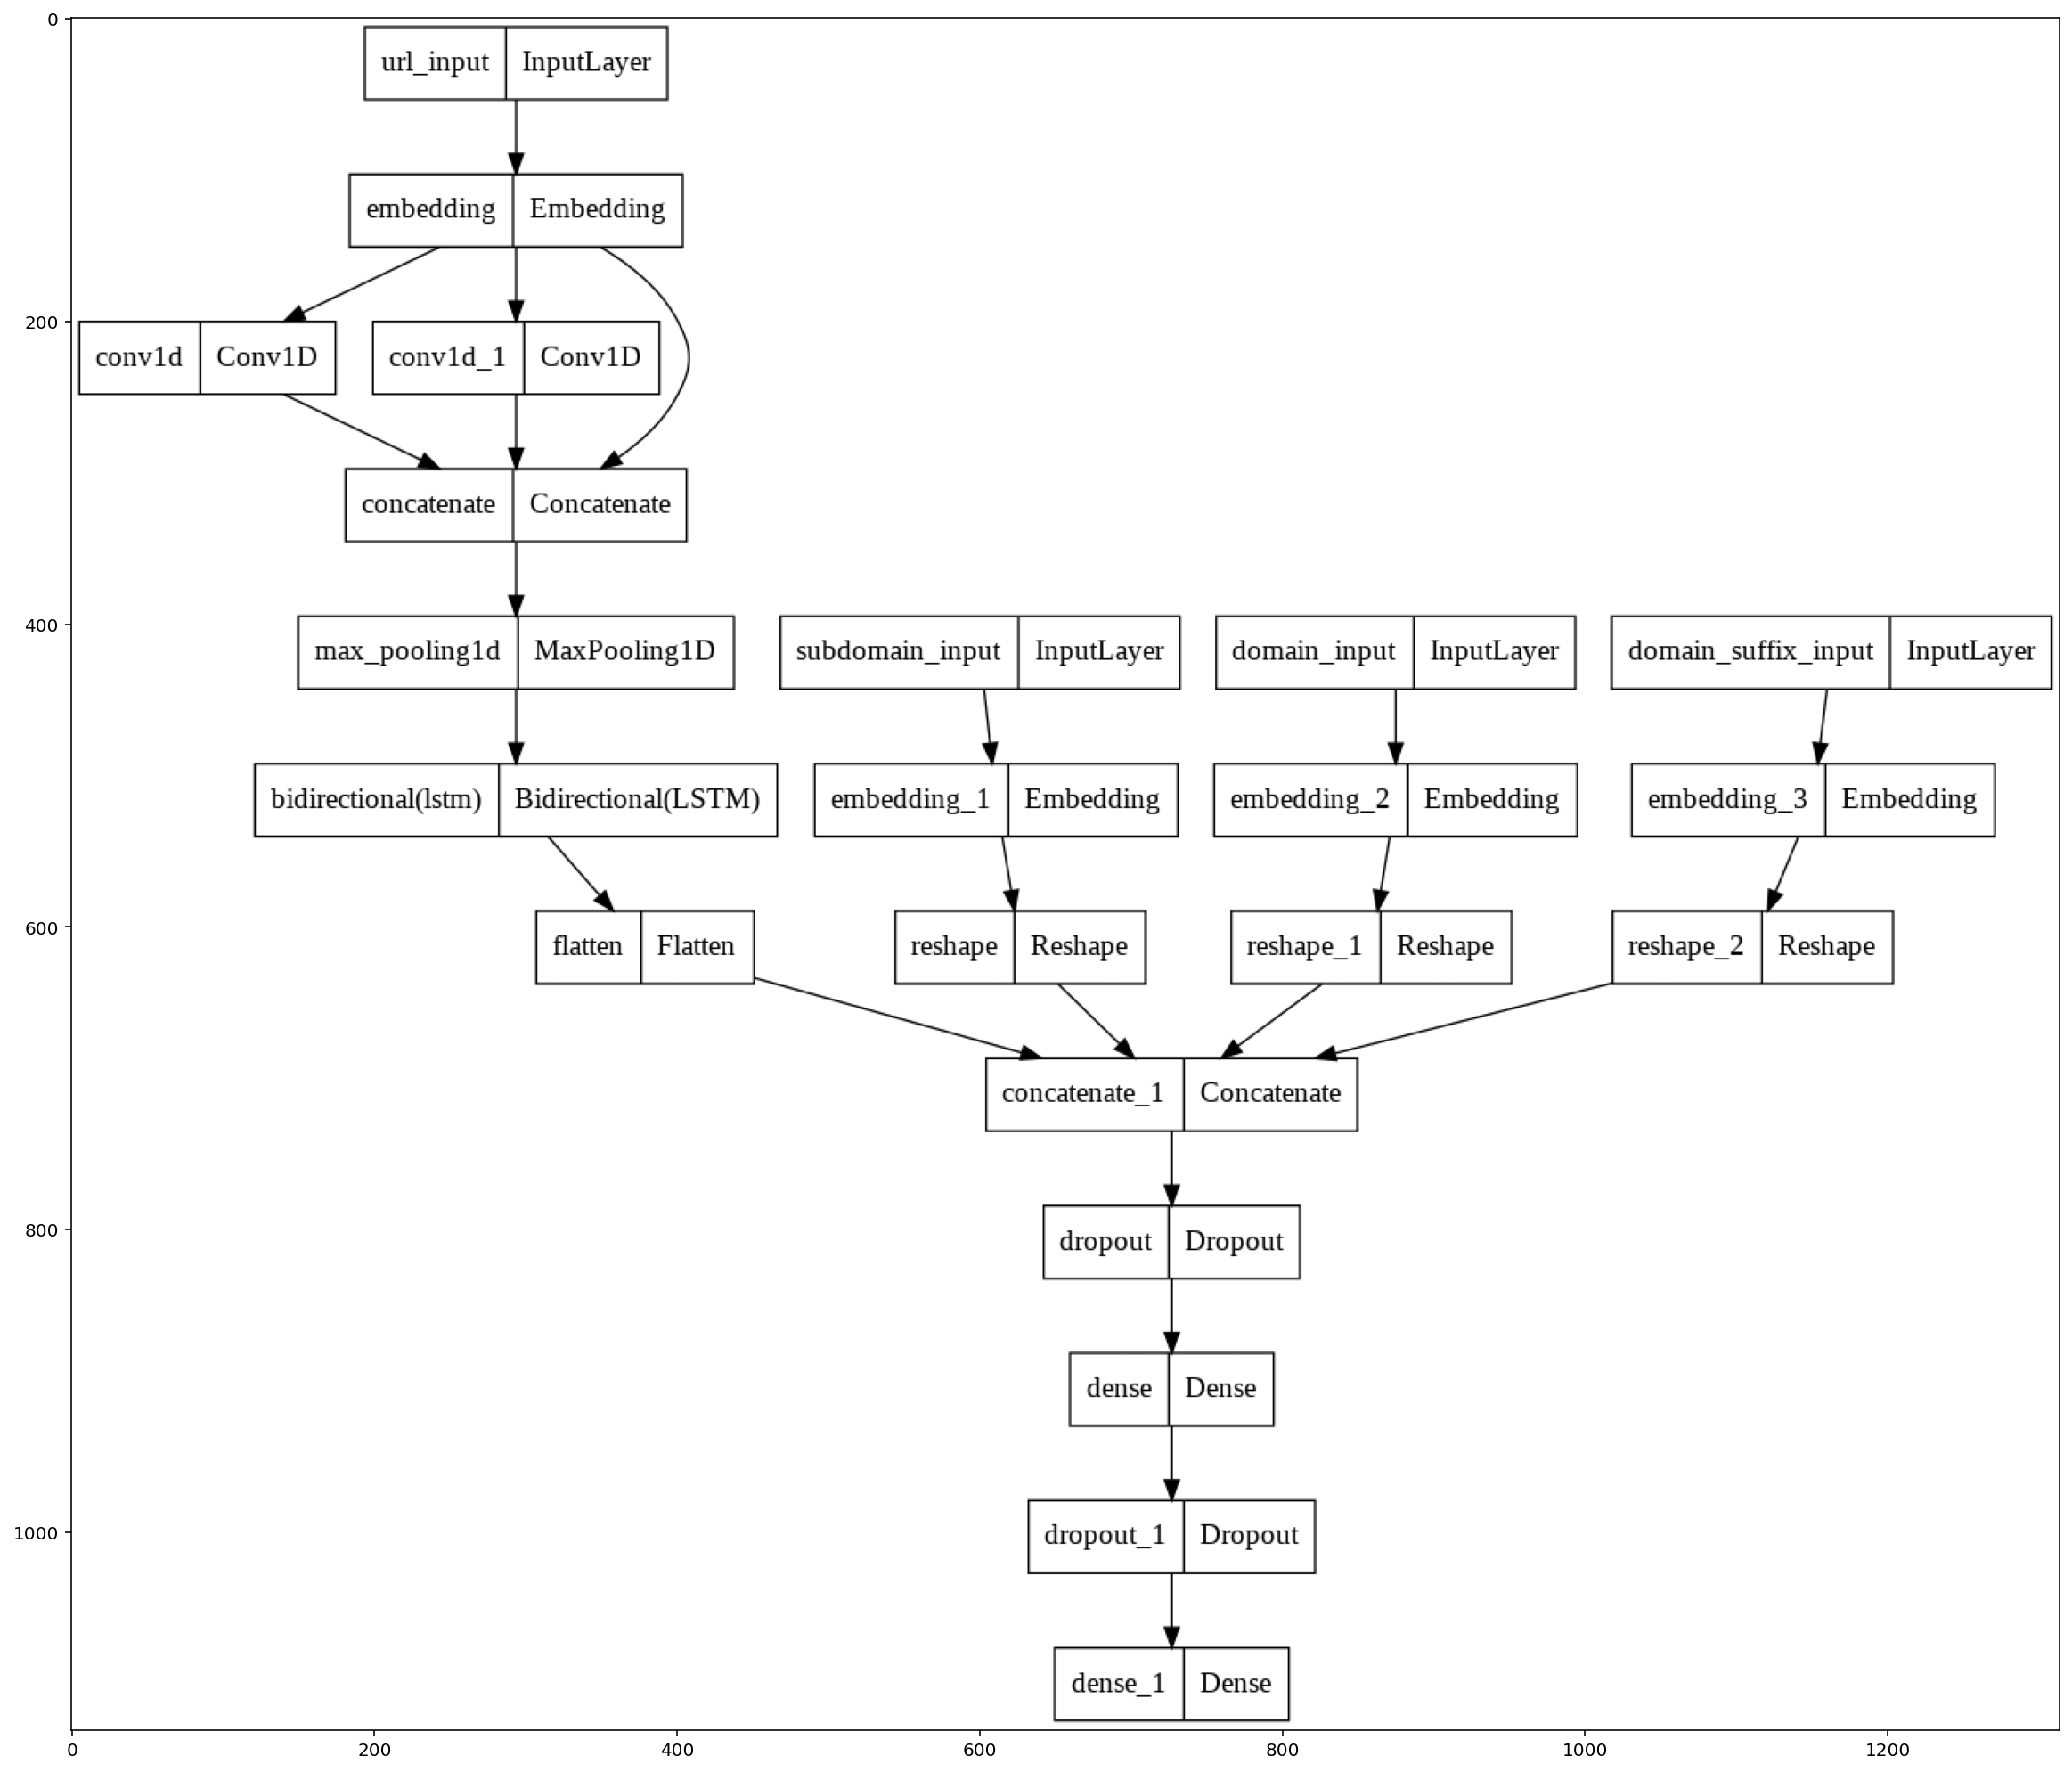

In [ ]:
# show model architecture
plot_model(model, to_file='model.png')
model_image = mpimg.imread('model.png')
plt.figure(figsize=(20, 20))
plt.imshow(model_image)
plt.show()

In [ ]:
# model training
early_stopping = [EarlyStopping(monitor='val_precision', patience=3, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=64, epochs=15, verbose=1, validation_data=(val_x,val_y), shuffle=True, callbacks=early_stopping)
model.save('model.h5')

Epoch 1/15
8140/8140 [==============================] - 606s 74ms/step - loss: -146.5075 - precision: 0.8348 - recall: 0.9604 - val_loss: -299.3671 - val_precision: 0.9199 - val_recall: 0.9755
Epoch 2/15
8140/8140 [==============================] - 544s 67ms/step - loss: -449.2714 - precision: 0.8860 - recall: 0.9765 - val_loss: -606.4974 - val_precision: 0.9220 - val_recall: 0.9794
Epoch 3/15
3340/8140 [===========>..................] - ETA: 4:53 - loss: -668.2037 - precision: 0.8974 - recall: 0.9785

KeyboardInterrupt: ignored